In [1]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from einops import rearrange, repeat, einsum

ModuleNotFoundError: No module named 'einops'

In [ ]:
class MambaRMSNorm(nn.Module):
    def __init__(self,
                 d_model: int,
                 eps: float = 1e-5):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))
    def forward(self, x):
        output = x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps) * self.weight
        return output
    

class MinimalMamba(nn.Module):
    def __init__(self, d_model,d_inner,dt_rank,d_state,bias=True):
        """A single Mamba block, as described in Figure 3 in Section 3.4 in the Mamba paper [1]."""
        #Mitchell's note: d_model is the dimensionality of the input and output (the embedding)
        #d_inner is the dimensionality of the input to the SSM 
        #d_state is the dimensionality of the state space for each input
        super().__init__()
        self.d_inner = d_inner
        self.d_model = d_model
        self.dt_rank = dt_rank
        self.d_state = d_state
        
        self.in_proj = nn.Linear(d_model, d_inner * 2, bias=bias)

        # x_proj takes in `x` and outputs the input-specific Δ, B, C
        self.x_proj = nn.Linear(d_inner, dt_rank + d_state * 2, bias=False)
        
        # dt_proj projects Δ from dt_rank to d_in
        self.dt_proj = nn.Linear(dt_rank, d_inner, bias=True)

        A = repeat(torch.arange(1, d_state + 1), 'n -> d n', d=d_inner)
        self.A_log = nn.Parameter(torch.log(A))
        self.D = nn.Parameter(torch.ones(d_inner))
        self.out_proj = nn.Linear(d_inner, d_model, bias=bias)
        self.norm = MambaRMSNorm(d_model)

    def forward(self, x):
        """Mamba block forward. This looks the same as Figure 3 in Section 3.4 in the Mamba paper [1].
    
        Args:
            x: shape (b, l, d)    (See Glossary at top for definitions of b, l, d_in, n...)
    
        Returns:
            output: shape (b, l, d)
        
        Official Implementation:
            class Mamba, https://github.com/state-spaces/mamba/blob/main/mamba_ssm/modules/mamba_simple.py#L119
            mamba_inner_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L311
            
        """

        (b, l, d) = x.shape
        x_copy = x # There was a separate class for residual, I deleted that part and added it here.
        x = self.norm(x)
        x_and_res = self.in_proj(x)  # shape (b, l, 2 * d_in)
        (x, res) = x_and_res.split(split_size=[self.d_inner, self.d_inner], dim=-1)

        x = rearrange(x, 'b l d_in -> b d_in l')
        x = rearrange(x, 'b d_in l -> b l d_in')
        
        x = F.silu(x)

        y = self.ssm(x)
        
        y = y * F.silu(res)
        
        output = self.out_proj(y) + x_copy

        return output,None

    
    def ssm(self, x):
        """Runs the SSM. See:
            - Algorithm 2 in Section 3.2 in the Mamba paper [1]
            - run_SSM(A, B, C, u) in The Annotated S4 [2]

        Args:
            x: shape (b, l, d_in)    (See Glossary at top for definitions of b, l, d_in, n...)
    
        Returns:
            output: shape (b, l, d_in)

        Official Implementation:
            mamba_inner_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L311
            
        """
        (d_in, n) = self.A_log.shape

        # Compute ∆ A B C D, the state space parameters.
        #     A, D are input independent (see Mamba paper [1] Section 3.5.2 "Interpretation of A" for why A isn't selective)
        #     ∆, B, C are input-dependent (this is a key difference between Mamba and the linear time invariant S4,
        #                                  and is why Mamba is called **selective** state spaces)
        
        A = -torch.exp(self.A_log.float())  # shape (d_in, n)
        D = self.D.float()

        x_dbl = self.x_proj(x)  # (b, l, dt_rank + 2*n)
        
        (delta, B, C) = x_dbl.split(split_size=[self.dt_rank, n, n], dim=-1)  # delta: (b, l, dt_rank). B, C: (b, l, n)
        delta = F.softplus(self.dt_proj(delta))  # (b, l, d_in)
        
        y = self.selective_scan(x, delta, A, B, C, D)  # This is similar to run_SSM(A, B, C, u) in The Annotated S4 [2]
        
        return y

    
    def selective_scan(self, u, delta, A, B, C, D):
        """Does selective scan algorithm. See:
            - Section 2 State Space Models in the Mamba paper [1]
            - Algorithm 2 in Section 3.2 in the Mamba paper [1]
            - run_SSM(A, B, C, u) in The Annotated S4 [2]

        This is the classic discrete state space formula:
            x(t + 1) = Ax(t) + Bu(t)
            y(t)     = Cx(t) + Du(t)
        except B and C (and the step size delta, which is used for discretization) are dependent on the input x(t).
    
        Args:
            u: shape (b, l, d_in)    (See Glossary at top for definitions of b, l, d_in, n...)
            delta: shape (b, l, d_in)
            A: shape (d_in, n)
            B: shape (b, l, n)
            C: shape (b, l, n)
            D: shape (d_in,)
    
        Returns:
            output: shape (b, l, d_in)
    
        Official Implementation:
            selective_scan_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L86
            Note: I refactored some parts out of `selective_scan_ref` out, so the functionality doesn't match exactly.
            
        """
        (b, l, d_in) = u.shape
        n = A.shape[1]
        
        # Discretize continuous parameters (A, B)
        # - A is discretized using zero-order hold (ZOH) discretization (see Section 2 Equation 4 in the Mamba paper [1])
        # - B is discretized using a simplified Euler discretization instead of ZOH. From a discussion with authors:
        #   "A is the more important term and the performance doesn't change much with the simplication on B"
        deltaA = torch.exp(einsum(delta, A, 'b l d_in, d_in n -> b d_in l n'))
        deltaB_u = einsum(delta, B, u, 'b l d_in, b l n, b l d_in -> b d_in l n')
        
        # Perform selective scan (see scan_SSM() in The Annotated S4 [2])
        x = torch.zeros((b, d_in, n), device=deltaA.device)
        self.hiddens = []
        ys = []    
        for i in range(l):
            x = deltaA[:, :, i] * x + deltaB_u[:, :, i]
            self.hiddens.append(x)
            y = einsum(x, C[:, i, :], 'b d_in n, b n -> b d_in')
            ys.append(y)
        y = torch.stack(ys, dim=1)  # shape (b, l, d_in)
        self.hiddens = torch.stack(self.hiddens, dim=1)
        y = y + u * D
    
        return y



    

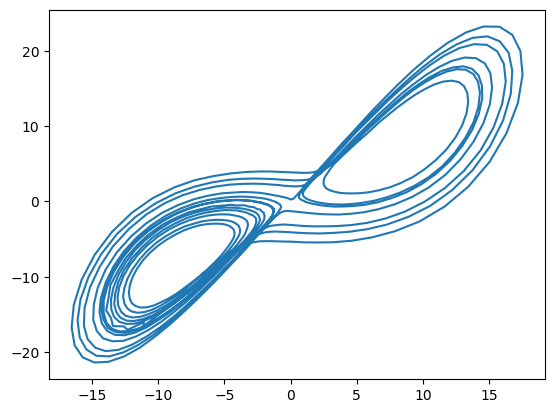

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from dysts.flows import Lorenz, Hadley

## Load and simulate an attractor
model = Lorenz()
sol = model.make_trajectory(1000, resample=True,noise=0.01)
plt.figure()
plt.plot(sol[:, 0], sol[:, 1])

In [46]:
model = MinimalMamba(1,1,1,100)

In [47]:
data = torch.tensor(sol[np.newaxis,:,0:1]).float()
print(data.size())
out,_ = model(data)
out.shape, model.hiddens.shape

torch.Size([1, 1000, 1])


(torch.Size([1, 1000, 1]), torch.Size([1, 1000, 1, 100]))

In [48]:
hidden = model.hiddens.detach().numpy().squeeze()

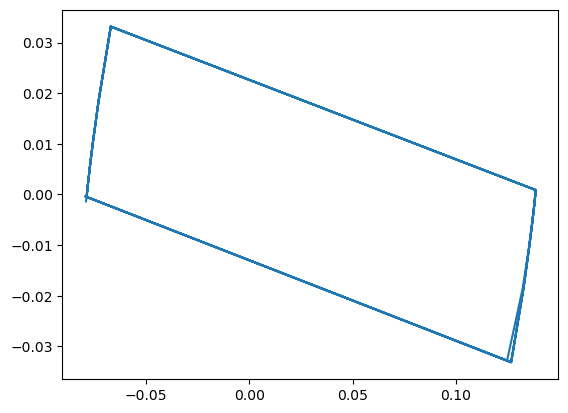

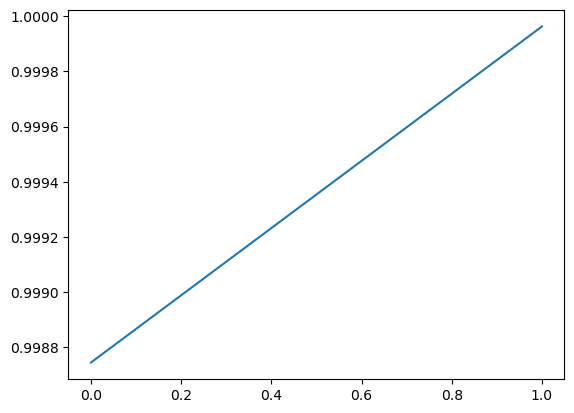

In [49]:
#run pca on the hidden states
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(hidden)
hidden_pca = pca.transform(hidden)
plt.figure()
plt.plot(hidden_pca[:,0],hidden_pca[:,1])
plt.figure()
#plot evr
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [51]:
from utils import train,make_dataset
from torch.optim import AdamW

model = MinimalMamba(1,1,10,100)
train_loader, val_loader, train_data, val_data = make_dataset(Lorenz,1000,20)

#model,train_set,val_set,epochs,lr,optimizer,loss_fn,device
model, train_loss, val_loss = train(model, train_loader, val_loader, 50, 1e-3,AdamW, nn.MSELoss(), 'cpu')
plt.plot(train_loss)
plt.plot(val_loss)

(20, 1000, 3) torch.Size([20, 1000, 1])
(20, 1000, 3) torch.Size([20, 1000, 1])


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 Training Loss: 0.41246345490217207


  2%|▏         | 1/50 [00:47<38:24, 47.04s/it]

Epoch 0 Validation Loss: 0.4006382644176483
Epoch 1 Training Loss: 0.4109527923166752


  4%|▍         | 2/50 [01:28<35:11, 44.00s/it]

Epoch 1 Validation Loss: 0.4002749152481556
Epoch 2 Training Loss: 0.41086604744195937


  6%|▌         | 3/50 [02:11<33:57, 43.36s/it]

Epoch 2 Validation Loss: 0.400263362377882
Epoch 3 Training Loss: 0.4108582466840744


  8%|▊         | 4/50 [02:49<31:29, 41.07s/it]

Epoch 3 Validation Loss: 0.4002582594752312
Epoch 4 Training Loss: 0.41085041910409925


 10%|█         | 5/50 [04:23<45:12, 60.29s/it]

Epoch 4 Validation Loss: 0.400252902507782
Epoch 5 Training Loss: 0.4108488276600838


 12%|█▏        | 6/50 [06:16<57:21, 78.21s/it]

Epoch 5 Validation Loss: 0.40025189965963365
Epoch 6 Training Loss: 0.4108489975333214


 14%|█▍        | 7/50 [34:26<7:13:48, 605.31s/it]

Epoch 6 Validation Loss: 0.40025191232562063
Epoch 7 Training Loss: 0.410846945643425


 16%|█▌        | 8/50 [1:15:51<14:02:31, 1203.61s/it]

Epoch 7 Validation Loss: 0.4002515383064747
Epoch 8 Training Loss: 0.4108505010604858


 18%|█▊        | 9/50 [1:17:11<9:42:19, 852.19s/it]  

Epoch 8 Validation Loss: 0.40024702474474905
Epoch 9 Training Loss: 0.4108481861650944


 20%|██        | 10/50 [1:18:24<6:47:51, 611.79s/it]

Epoch 9 Validation Loss: 0.4002481661736965
Epoch 10 Training Loss: 0.4108404740691185


 22%|██▏       | 11/50 [1:19:42<4:51:23, 448.30s/it]

Epoch 10 Validation Loss: 0.40024312660098077
Epoch 11 Training Loss: 0.4108389146625996


 24%|██▍       | 12/50 [1:23:02<3:56:07, 372.82s/it]

Epoch 11 Validation Loss: 0.40023984014987946
Epoch 12 Training Loss: 0.4108365438878536


 26%|██▌       | 13/50 [1:26:23<3:17:49, 320.80s/it]

Epoch 12 Validation Loss: 0.4002402886748314
